In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/FirstCompetition/

/gdrive/MyDrive/FirstCompetition


In [ ]:
!pip install visualkeras
!pip install keras-tuner

     |████████████████████████████████| 795 kB 5.4 MB/s 
     |████████████████████████████████| 98 kB 3.2 MB/s 


In [ ]:
import tensorflow as tf
import keras_tuner as kt
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import shutil


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import visualkeras

tfk = tf.keras
tfkl = tfk.layers

In [ ]:
# Random seed for reproducibility
seed = 333

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
DB_BASE = 'dataset'
TRAIN_DIR_BASE = DB_BASE + '/training'
TEST_DIR_BASE = DB_BASE + '/test'

IMAGE_SIZE = (256,256)
CHANNELS = 3
INPUT_SHAPE = (IMAGE_SIZE)+(CHANNELS,)

BATCH_SIZE = 128
EPOCHS = 500

labels = ['Apple',        # 0
          'Blueberry',    # 1
          'Cherry',       # 2
          'Corn',         # 3
          'Grape',        # 4
          'Orange',       # 5
          'Peach',        # 6
          'Pepper',       # 7
          'Potato',       # 8
          'Raspberry',    # 9
          'Soybean',      # 10
          'Squash',       # 11
          'Strawberry',   # 12
          'Tomato'        # 13
]

# Initialize data generators and class weights

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_train_val_generators(ds_dir=TRAIN_DIR_BASE,
                             batch_size=BATCH_SIZE,
                             img_size=IMAGE_SIZE,
                             val_split=0.1,
                             seed=seed):
    
    width_shift_range=0.2
    height_shift_range=0.2
    zoom_range=0.2
    horizontal_flip=True
    vertical_flip=True
    rotation_range=30
    
    train_datagen = ImageDataGenerator(
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        rotation_range=rotation_range,
        validation_split=val_split)

    train_generator = train_datagen.flow_from_directory(
        ds_dir,
        target_size=(img_size[0],img_size[1]),
        color_mode = 'rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        seed = seed)

    val_generator = train_datagen.flow_from_directory(
        ds_dir,
        target_size=(img_size[0],img_size[1]),
        color_mode = 'rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        seed = seed)
    
    return train_generator, val_generator

train_generator, val_generator = get_train_val_generators()

Found 15972 images belonging to 14 classes.
Found 1766 images belonging to 14 classes.


In [ ]:
# CLASS WEIGHTS

# Number of elements of each class
class_distr = []
for i in range(14):
    class_distr.append(sum(1 for x in train_generator.labels if x == i))

# Class Weights calculation
class_weights = []
total = train_generator.labels.size
for i in range(14):
    class_weights.append((i,(1/class_distr[i]) * (total/14.0)))

class_weights  = {cat:weight for (cat,weight) in class_weights}
for cat,weight in class_weights.items():
    print(labels[cat],'->',weight)

Apple -> 1.2818619582664528
Blueberry -> 2.7098744485917883
Cherry -> 2.1730612244897958
Corn -> 1.0505130228887136
Grape -> 0.8688934827548689
Orange -> 0.7248139408241061
Peach -> 1.2964285714285715
Pepper -> 1.6558158822309765
Potato -> 1.744429882044561
Raspberry -> 4.793517406962785
Soybean -> 0.7840942562592048
Squash -> 2.2066869300911853
Strawberry -> 1.8826025459688827
Tomato -> 0.2226497156239545


# Model Definition

In [ ]:
def build_model(hp,
                input_shape = INPUT_SHAPE,
                image_h = IMAGE_SIZE[0],
                image_w = IMAGE_SIZE[1],
                mnet_train = False):

    # HYPERPARAMETERS TO BE TUNED
    # test different dropout rates
    hp_drop_rate = hp.Float('dropout_rate',
                            min_value = 0.1,
                            max_value = 0.5,
                            step = 0.2,
                            default = 0.3)

    # test different learning rates
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # test different number of hidden layers
    hp_num_hl = hp.Int('n_hidden_layers',1,2) # different number of units are also tested (see for cycle)

    # MODEL
    model = tfk.Sequential()

    # Input
    model.add(tfkl.Input(shape=input_shape, name='Input'))

    # Resize and Rescale
    model.add(tfkl.Resizing(image_h, image_w, interpolation='bicubic', name='Resize'))
    model.add(tfkl.Rescaling(scale = 1./127.5, offset = -1, name='Rescale'))

    # Convolutional Net
    # Import MobileNetV3
    Xception = tfk.applications.Xception(weights = 'imagenet',
                                         input_shape = input_shape,
                                         include_top = False)
    Xception.trainable = mnet_train
    model.add(Xception)

    # Flatten
    model.add(tfkl.Flatten(name='Fatten'))
    model.add(tfkl.Dropout(hp_drop_rate, seed=seed))

    # Hidden Layer(s)                
    for i in range(hp_num_hl):

        # test different number of units of hidden layer(s)
        hp_units_hl = hp.Int('units_hl_'+str(i),
                              min_value = 128,
                              max_value = 256,
                              step = 128)

        model.add(tfkl.Dense(units = hp_units_hl,
                             activation = 'relu',
                             kernel_initializer = tfk.initializers.GlorotUniform(seed)))

        model.add(tfkl.Dropout(hp_drop_rate, seed=seed))

    # Output Layer
    model.add(tfkl.Dense(units = 14,
                         name = 'Output',
                         activation = 'softmax',
                         kernel_initializer = tfk.initializers.GlorotUniform(seed)))

    # Compile the model
    model.compile(loss = tfk.losses.CategoricalCrossentropy(),
                  optimizer = tfk.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics = 'accuracy')

    # Return the model
    return model

# Hyperparameters tuning

In [ ]:
tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy',
                     max_epochs = 20,
                     factor = 3,
                     seed = seed,
                     directory = 'tuner_Xception',
                     project_name = 'tuner_Xception')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# gen_zip_callback = GenZipCallback()

# Search best hyperparameters
tuner.search(x = train_generator,
             batch_size = BATCH_SIZE,
             epochs = EPOCHS,
             validation_data = val_generator,
             class_weight = class_weights,
             callbacks = [early_stop])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Initialize and save best model
model = tuner.hypermodel.build(best_hps)
model.save('EricaTest2/TransferLearningXception__tuned')

Trial 31 Complete [01h 09m 24s]
val_accuracy: 0.412395715713501

Best val_accuracy So Far: 0.7830750942230225
Total elapsed time: 09h 10m 36s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception__tuned/assets


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception__tuned/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# Callbacks Definition

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

    exps_dir = os.path.join('EricaTest2')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%d_%b_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = []

    # MODEL CHECKPOINTS
    ckpt_dir = os.path.join(exp_dir, 'checkpoints')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, now+'.ckpt'), 
                                                     save_weights_only=False,
                                                     save_best_only=False)
    callbacks.append(ckpt_callback)

    # VISUALIZE LEARNING ON TENSORBOARD
    tb_dir = os.path.join(exp_dir, 'tensorboard_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                                 profile_batch=0,
                                                 histogram_freq=1)  # if > 0 (epochs) shows weights histograms
    callbacks.append(tb_callback)

    # EARLY STOPPING
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    callbacks.append(es_callback)

    return callbacks

# Model Training

In [ ]:
model = tfk.models.load_model('EricaTest2/TransferLearningXception__tuned')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Resize (Resizing)           (None, 256, 256, 3)       0         
                                                                 
 Rescale (Rescaling)         (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 Fatten (Flatten)            (None, 131072)            0         
                                                                 
 dropout_2 (Dropout)         (None, 131072)            0         
                                                                 
 dense_1 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_3 (Dropout)         (None, 256)              

In [ ]:
callbacks = create_folders_and_callbacks(model_name='TransferLearningXception_freezed')
tf.autograph.set_verbosity(0)

# Train the model
history = model.fit(
          x = train_generator,
          batch_size=BATCH_SIZE,
          epochs = EPOCHS,
          validation_data = val_generator,
          class_weight=class_weights,
          callbacks = callbacks).history


In [ ]:
# Save best epoch model
model.save('EricaTest2/TransferLearningXception_freezed__BEST')

# Freezed Model Performance

In [ ]:
model = tfk.models.load_model('EricaTest2/TransferLearningXception_freezed__BEST')

In [ ]:
width_shift_range=0.2
height_shift_range=0.2
zoom_range=0.2
horizontal_flip=True
vertical_flip=True
rotation_range=30
val_split=0.2

datagen = ImageDataGenerator(
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip,
    rotation_range=rotation_range,
    validation_split=val_split)

val_generator = datagen.flow_from_directory(
    TRAIN_DIR_BASE,
    target_size=(IMAGE_SIZE[0],IMAGE_SIZE[1]),
    color_mode = 'rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False)

prediction_prob = model.predict(val_generator)

# get actual predictions (higher predicted probability)
predictions = []
for el in prediction_prob:
    predictions.append(np.argmax(el,axis = 0))

# create confusion matrix
conf_mat = np.zeros((14,14))
for (pr,label) in zip(predictions,val_generator.labels):
    conf_mat[label][pr] += 1

# accuracy
true_positives = np.trace(conf_mat)
accuracy = float(true_positives) / conf_mat.sum()

# normalize confusion matrix
for row in conf_mat:
    row /= np.sum(row)
    
datagen = None
val_generator = None

Found 3541 images belonging to 14 classes.


accuracy: 0.7647557187235244


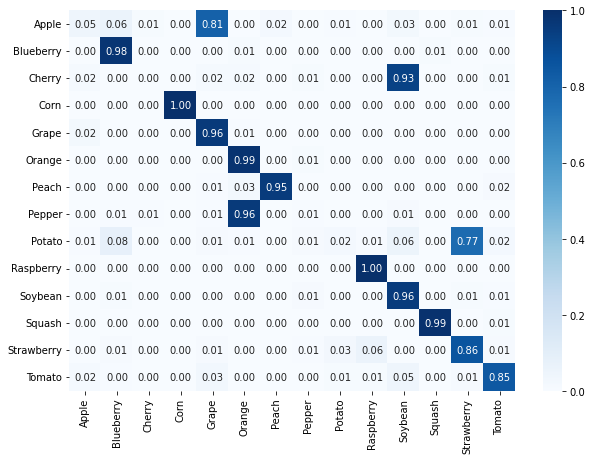

In [ ]:
print('accuracy: ' + str(accuracy))

df_cm = pd.DataFrame(conf_mat, index = labels, columns = labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')

# Train with Xception trainable

In [ ]:
# Unfreeze the base model
model.trainable = True

model.compile(optimizer=tfk.optimizers.Adam(1e-5),    # Very low learning rate#
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Resize (Resizing)           (None, 256, 256, 3)       0         
                                                                 
 Rescale (Rescaling)         (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 Fatten (Flatten)            (None, 131072)            0         
                                                                 
 dropout_2 (Dropout)         (None, 131072)            0         
                                                                 
 dense_1 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_3 (Dropout)         (None, 256)              

In [ ]:
callbacks = create_folders_and_callbacks(model_name='TransferLearningXception_FineTuning')

tf.autograph.set_verbosity(0)

# Train the model
history = model.fit(
          x = train_generator,
          batch_size=BATCH_SIZE,
          epochs = EPOCHS,
          validation_data = val_generator,
          class_weight=class_weights,
          callbacks = callbacks).history

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/500
125/125 [==============================] - ETA: 0s - loss: 2.0638 - accuracy: 0.5262 

INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


125/125 [==============================] - 2577s 20s/step - loss: 2.0638 - accuracy: 0.5262
Epoch 2/500
125/125 [==============================] - ETA: 0s - loss: 1.9271 - accuracy: 0.5685 

INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


125/125 [==============================] - 1821s 15s/step - loss: 1.9271 - accuracy: 0.5685
Epoch 3/500
125/125 [==============================] - ETA: 0s - loss: 1.9061 - accuracy: 0.5803 

INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


125/125 [==============================] - 1854s 15s/step - loss: 1.9061 - accuracy: 0.5803
Epoch 4/500
125/125 [==============================] - ETA: 0s - loss: 1.8870 - accuracy: 0.5855 

INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


125/125 [==============================] - 2029s 16s/step - loss: 1.8870 - accuracy: 0.5855
Epoch 5/500
125/125 [==============================] - ETA: 0s - loss: 1.8851 - accuracy: 0.5878 

INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


125/125 [==============================] - 2133s 17s/step - loss: 1.8851 - accuracy: 0.5878
Epoch 6/500
125/125 [==============================] - ETA: 0s - loss: 1.8697 - accuracy: 0.5962 

INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


125/125 [==============================] - 2078s 17s/step - loss: 1.8697 - accuracy: 0.5962
Epoch 7/500
125/125 [==============================] - ETA: 0s - loss: 1.8585 - accuracy: 0.6017 

INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


125/125 [==============================] - 2086s 17s/step - loss: 1.8585 - accuracy: 0.6017
Epoch 8/500
125/125 [==============================] - ETA: 0s - loss: 1.8560 - accuracy: 0.6010 

INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


125/125 [==============================] - 2181s 17s/step - loss: 1.8560 - accuracy: 0.6010
Epoch 9/500
125/125 [==============================] - ETA: 0s - loss: 1.8520 - accuracy: 0.6004 

INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


125/125 [==============================] - 2195s 18s/step - loss: 1.8520 - accuracy: 0.6004
Epoch 10/500
125/125 [==============================] - ETA: 0s - loss: 1.8644 - accuracy: 0.5975 

INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


125/125 [==============================] - 2210s 18s/step - loss: 1.8644 - accuracy: 0.5975
Epoch 11/500
125/125 [==============================] - ETA: 0s - loss: 1.8435 - accuracy: 0.6054 

INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


125/125 [==============================] - 2221s 18s/step - loss: 1.8435 - accuracy: 0.6054
Epoch 12/500
125/125 [==============================] - ETA: 0s - loss: 1.8490 - accuracy: 0.6009 

INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


125/125 [==============================] - 2316s 19s/step - loss: 1.8490 - accuracy: 0.6009
Epoch 13/500
125/125 [==============================] - ETA: 0s - loss: 1.8469 - accuracy: 0.6026 

INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


125/125 [==============================] - 2395s 19s/step - loss: 1.8469 - accuracy: 0.6026
Epoch 14/500
125/125 [==============================] - ETA: 0s - loss: 1.8467 - accuracy: 0.6042 

INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets


INFO:tensorflow:Assets written to: EricaTest2/TransferLearningXception_FineTuning_24_Nov_15-28-09/checkpoints/24_Nov_15-28-09.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


125/125 [==============================] - 2374s 19s/step - loss: 1.8467 - accuracy: 0.6042
Epoch 15/500
 99/125 [======================>.......] - ETA: 8:18 - loss: 1.8326 - accuracy: 0.6012

In [ ]:
# Save best epoch model
model.save('EricaTest2/TransferLearningXception__FineTuning')

# Unfreezed Model Performance

In [ ]:
model = tfk.models.load_model('EricaTest2/TransferLearningXception__FineTuning')

In [ ]:
width_shift_range=0.2
height_shift_range=0.2
zoom_range=0.2
horizontal_flip=True
vertical_flip=True
rotation_range=30
val_split=0.2

datagen = ImageDataGenerator(
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip,
    rotation_range=rotation_range)

val_generator = datagen.flow_from_directory(
    TEST_DIR_BASE,
    target_size=(IMAGE_SIZE[0],IMAGE_SIZE[1]),
    color_mode = 'rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

prediction_prob = model.predict(val_generator)

# get actual predictions (higher predicted probability)
predictions = []
for el in prediction_prob:
    predictions.append(np.argmax(el,axis = 0))

# create confusion matrix
conf_mat = np.zeros((14,14))
for (pr,label) in zip(predictions,val_generator.labels):
    conf_mat[label][pr] += 1

# accuracy
true_positives = np.trace(conf_mat)
accuracy = float(true_positives) / conf_mat.sum()

# normalize confusion matrix
for row in conf_mat:
    row /= np.sum(row)

datagen = None
val_generator = None

In [ ]:
print('accuracy: ' + str(accuracy))

df_cm = pd.DataFrame(conf_mat, index = labels, columns = labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')